In [13]:
#D'abord vérifier si on a du Lenet

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing 
from keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics
%matplotlib inline


Using TensorFlow backend.


In [26]:


def dictionnaire_conversion():
    dic_labels_to_num={}
    dic_num_to_labels={}

    dic_labels_to_num["autre"]=0
    dic_labels_to_num["chevreuil"]=1
    dic_labels_to_num["corneille"]=2
    dic_labels_to_num["faisan"]=3
    dic_labels_to_num["lapin"]=4
    dic_labels_to_num["pigeon"]=5
    dic_labels_to_num["oiseau"]=6
    
    dic_num_to_labels[0]="autre"
    dic_num_to_labels[1]="chevreuil"
    dic_num_to_labels[2]="corneille"
    dic_num_to_labels[3]="faisan"
    dic_num_to_labels[4]="lapin"
    dic_num_to_labels[5]="pigeon"
    dic_num_to_labels[6]="oiseau"
    
    return dic_labels_to_num,dic_num_to_labels




def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [27]:
#Essayons de faire lenet avec tf voir ci-dessous . Il y a aussi une commande pour voir le résumer peut être .resume
def build_model(width, height, depth, classes,drop_out_rate):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(30, (5, 5), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
        
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(16, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),

        
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(128),
		Activation("relu"),
		BatchNormalization(),
		Dropout(drop_out_rate),
        
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [4]:
#Paramètres

#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2
epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.3
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1


In [5]:

base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()


All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    

class: 13
img_paths: 6220


In [6]:
dic_labels_to_num,dic_num_to_labels=dictionnaire_conversion()

n_path="/mnt/VegaSlowDataDisk/c3po/Annotation_automatique/"
gen_imagettes=pd.read_csv(n_path+"fp+an_gen_tf.csv")

folder_imagettes="tf_200ep/"

liste_img_paths=[]
for i in range(len(gen_imagettes)):
    liste_img_paths.append(n_path+folder_imagettes+gen_imagettes["imagetteName"].iloc[i])

gen_imagettes["img_paths"]=liste_img_paths
gen_imagettes.head()

gen_imagettes["class"]="autre"

for i in range(len(gen_imagettes)):
    if gen_imagettes["IsFP"].iloc[i]==0:
        gen_imagettes["class"].iloc[i]=dic_num_to_labels[gen_imagettes["reel_classe"].iloc[i]]
    
gen_imagettes.head()  

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,path,filename,imagetteName,max_cat,predict_cat,xmin,xmax,ymin,ymax,former_index,IsFP,reel_classe,img_paths,class
0,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-30.jpg,image_2019-04-30_18-17-30_356_51_5.jpg,0.513831,5.0,509,518,290,298,356.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
1,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-30.jpg,image_2019-04-30_18-17-30_295_91_5.jpg,0.914196,5.0,992,1014,321,339,295.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
2,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-30.jpg,image_2019-04-30_18-17-30_296_93_2.jpg,0.932135,2.0,1197,1211,319,333,296.0,0,2,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
3,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-47.jpg,image_2019-04-30_18-17-47_689_74_5.jpg,0.742045,5.0,982,987,334,339,689.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
4,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-47.jpg,image_2019-04-30_18-17-47_683_73_5.jpg,0.725646,5.0,853,867,339,356,683.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre


In [7]:
gen_imagettes=gen_imagettes[gen_imagettes["class"]!="autre"]

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'max_cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index','reel_classe','IsFP','predict_cat']
gen_imagettes.drop(to_drop,inplace=True,axis=1)
gen_imagettes.head()

,img_paths,class
2,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
7,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
8,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,oiseau
14,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
17,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille


In [8]:
n_path="/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_images/"



fp_new=pd.read_csv("/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_threshold/table_fp_new.csv")

liste_img_paths=[]
for i in range(len(fp_new)):
    liste_img_paths.append(n_path+fp_new["imagetteName"].iloc[i])

fp_new["img_paths"]=liste_img_paths
#imagetteNamefp_new.head()

fp_new["class"]="autre"
fp_new.columns

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index']

fp_new.drop(to_drop,axis=1,inplace=True)

#df=pd.concat([df,fp_new])

In [19]:
#gen_imagettes.drop("predict_cat",inplace=True,axis=1)
df=pd.concat([df,gen_imagettes,fp_new])

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [20]:
df=df[df["class"]!="oiseau"]

In [21]:
df["class"].unique()

array(['autre', 'corneille', 'pigeon', 'chevreuil', 'lapin', 'faisan'],
      dtype=object)

In [23]:
df.shape

(53198, 2)

In [24]:
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input
        # data augmentation
        #rotation_range = 10,
        #zoom_range = zoom_range,
        #horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]


Found 42558 validated image filenames belonging to 6 classes.
Found 10640 validated image filenames belonging to 6 classes.


In [ ]:
#First test the influence of number of epochs on the other recall

In [30]:
#Avec Ajout
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
model.save("tf_fp+match_100ep")

              precision    recall  f1-score   support

           0    0.99031   0.98715   0.98873      9728
           1    0.70588   0.90000   0.79121        40
           2    0.90441   0.83296   0.86722       443
           3    0.78125   0.79365   0.78740       126
           4    0.55224   0.80435   0.65487        46
           5    0.77855   0.87549   0.82418       257

    accuracy                        0.97462     10640
   macro avg    0.78544   0.86560   0.81893     10640
weighted avg    0.97618   0.97462   0.97512     10640

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tf_fp+match_100ep/assets


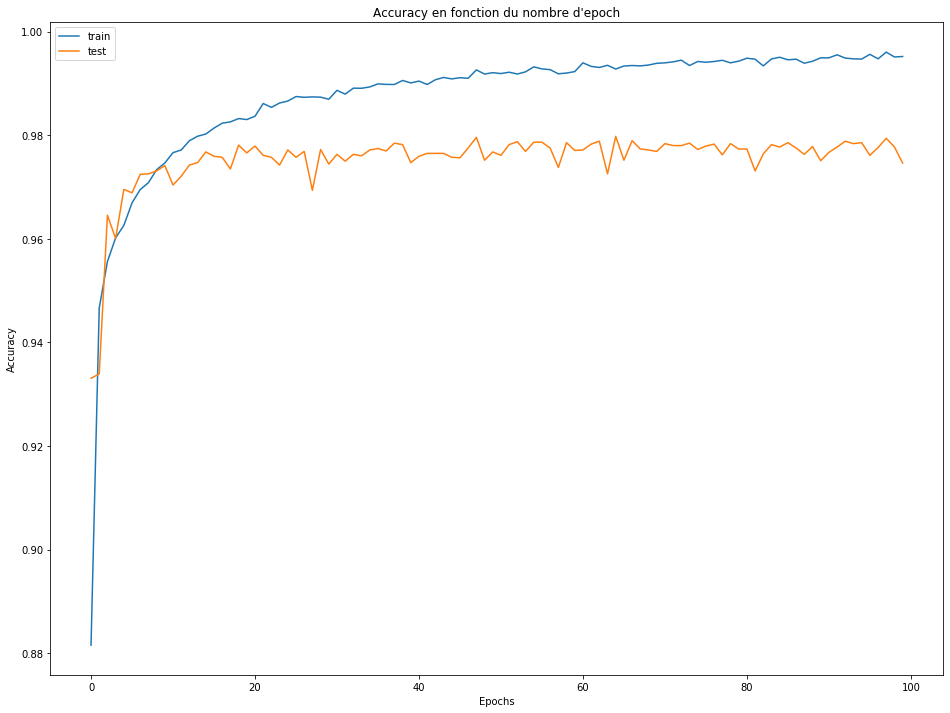

In [31]:
plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();

              precision    recall  f1-score   support

           0    0.99515   0.98489   0.99000      9798
           1    0.84314   0.91489   0.87755        47
           2    0.89951   0.89512   0.89731       410
           3    0.71094   0.87500   0.78448       104
           4    0.49254   0.86842   0.62857        38
           5    0.76471   0.90947   0.83083       243

    accuracy                        0.97791     10640
   macro avg    0.78433   0.90797   0.83479     10640
weighted avg    0.98096   0.97791   0.97899     10640

INFO:tensorflow:Assets written to: tf_fp+match_200ep/assets


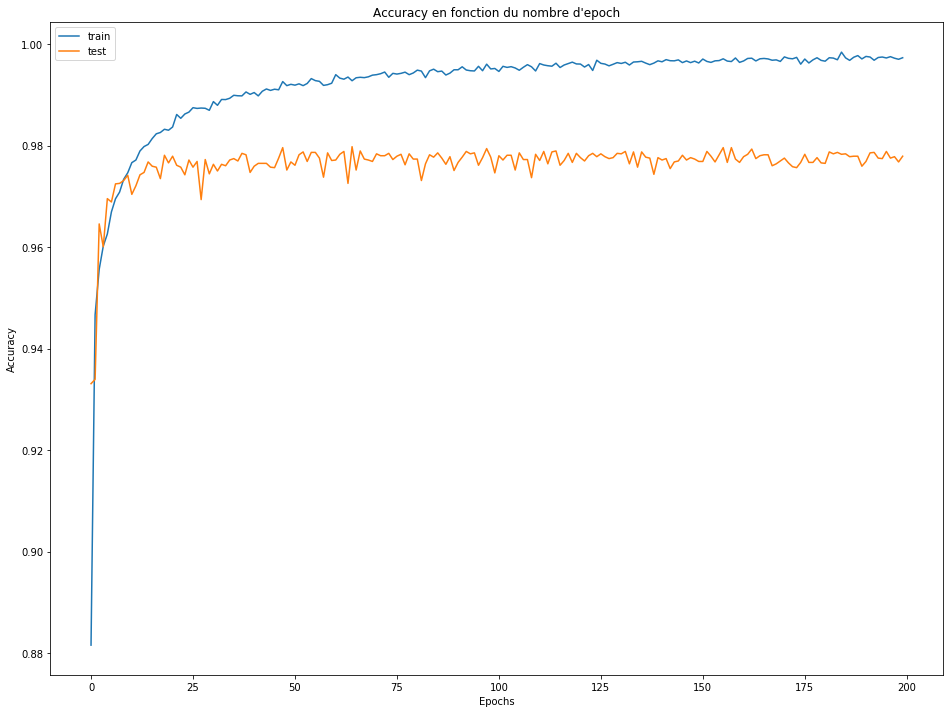

In [32]:
#Avec Ajout
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
model.save("tf_fp+match_200ep")



plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();




In [ ]:
#Maintenant avec moins de faux négatifs car j'ai peur du surapprentissage

In [34]:
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=0.5,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input
        # data augmentation
        #rotation_range = 10,
        #zoom_range = zoom_range,
        #horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]


Found 26599 validated image filenames belonging to 6 classes.
Found 26599 validated image filenames belonging to 6 classes.


              precision    recall  f1-score   support

           0    0.99233   0.98052   0.98639     24535
           1    0.78125   0.73529   0.75758       136
           2    0.80294   0.88254   0.84086       928
           3    0.67500   0.84047   0.74870       257
           4    0.48193   0.74766   0.58608       107
           5    0.77147   0.87579   0.82032       636

    accuracy                        0.97105     26599
   macro avg    0.75082   0.84371   0.78999     26599
weighted avg    0.97424   0.97105   0.97226     26599

INFO:tensorflow:Assets written to: lessfp_100ep/assets


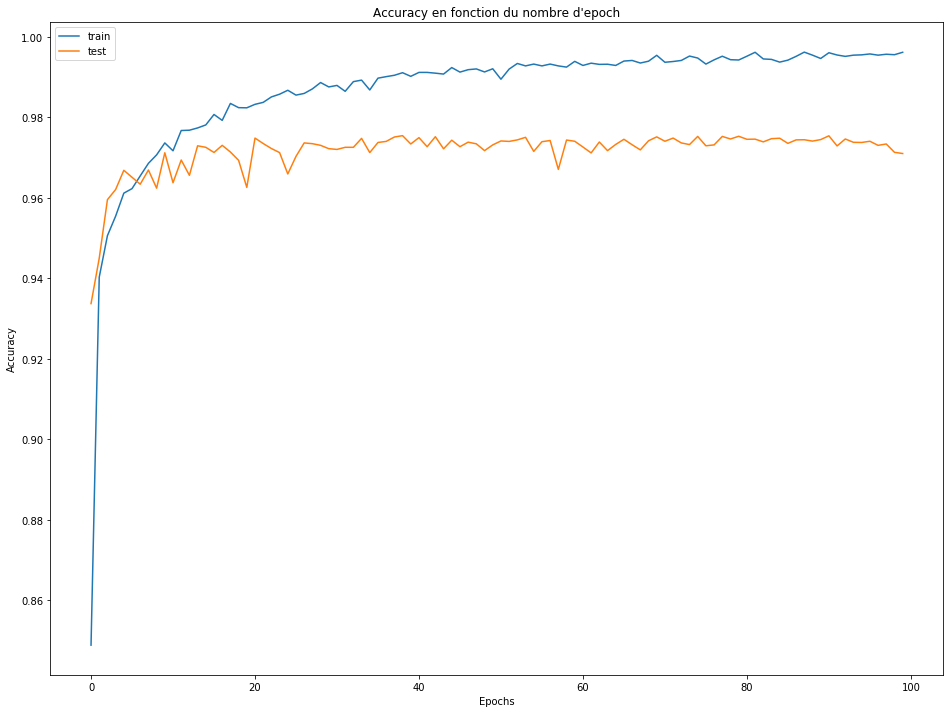

In [35]:
#Avec Ajout
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
model.save("lessfp_100ep")



plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();

              precision    recall  f1-score   support

           0    0.99414   0.97964   0.98684     24602
           1    0.68750   0.82243   0.74894       107
           2    0.79804   0.88865   0.84091       916
           3    0.74062   0.79264   0.76575       299
           4    0.37349   0.91176   0.52991        68
           5    0.76316   0.90774   0.82919       607

    accuracy                        0.97195     26599
   macro avg    0.72616   0.88381   0.78359     26599
weighted avg    0.97645   0.97195   0.97360     26599

INFO:tensorflow:Assets written to: lessfp_200ep/assets


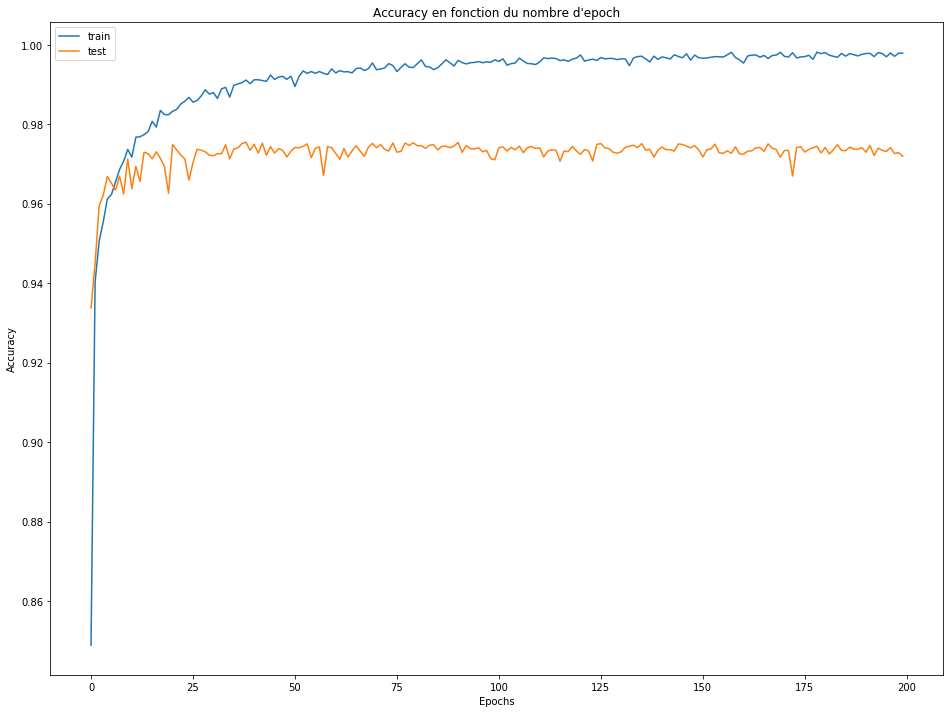

In [36]:
#Avec Ajout
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
model.save("lessfp_200ep")



plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();

In [2]:
import pandas as pd
index = ['Firefox', 'Chrome', 'Safari', 'IE10', 'Konqueror']

df = pd.DataFrame({'http_status': [200, 200, 404, 404, 301],

                  'response_time': [0.04, 0.02, 0.07, 0.08, 1.0]},

                  index=index)

In [10]:
df.reset_index()

,index,http_status,response_time
0,Firefox,200,0.04
1,Chrome,200,0.02
2,Safari,404,0.07
3,IE10,404,0.08
4,Konqueror,301,1.00
